##Exemplo de risco de PC

Neste caderno, apresentaremos um exemplo simples do PCHazard método descrito [neste artigo](https://arxiv.org/abs/1910.06724).

Para uma introdução mais detalhada, pycoxveja este [caderno](https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [12]:
# !pip install lifelines       # modelo convecional cox
# !pip install pycox           # pycox (baseado em PyTorch)
# !pip install scikit-survival # scikit-survival (integra com scikit-learn)
# !pip install scipy==1.10.1
# ! pip install sklearn-pandas #Uncomment to install `sklearn-pandas`

# Depois reniciar o ambiente de execução

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv


In [14]:
np.random.seed(1234)
_ = torch.manual_seed(123)

##Conjunto de dados
- Carregamos o conjunto de dados METABRIC e dividimos em treinamento, teste e validação.

- A duration coluna fornece os tempos observados e eventcontém indicadores de se a observação é um evento (1) ou uma observação censurada (0).

In [15]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [16]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


##Transformações de recursos
- O conjunto de dados METABRIC possui 9 covariáveis: x0, ..., x8. Padronizaremos as 5 covariáveis ​​numéricas e deixaremos as covariáveis ​​binárias como estão. Observe que o PyTorch requer variáveis ​​do tipo 'float32'.

Gostamos de usar o sklearn_pandas.DataFrameMapperpara criar mapeadores de recursos.

In [17]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [18]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

##Transformações de rótulos
- Os métodos de sobrevivência exigem transformações de rótulo individuais, por isso incluímos uma proposta label_transformpara cada método. Neste caso, label_transformé apenas uma abreviação para a classe pycox.preprocessing.label_transforms.LabTransDiscreteTime.

- Este PCHazardé um método de tempo contínuo, mas requer intervalos definidos nos quais o risco é constante. Portanto, precisamos realizar uma operação semelhante à discretização da escala de tempo. Deixamos _ num_durations...

In [19]:
num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [20]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

Observe que y_trainagora consiste em três rótulos: o índice do intervalo, o indicador do evento e a proporção do intervalo antes do evento/censura ocorrer (ou seja,ρ (teu)
no [jornal](https://arxiv.org/abs/1910.06724/) ).

In [21]:
y_train

(array([2, 2, 6, ..., 1, 5, 3]),
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32),
 array([0.7965465 , 0.69519496, 0.7370492 , ..., 0.06606603, 0.5865238 ,
        0.96302533], dtype=float32))

##Rede neural
- Criamos uma rede neural com torch. Para estruturas de rede simples, podemos usar o MLPVanillafornecido por torchtuples. Para construir arquiteturas de rede mais avançadas, veja, por exemplo, os [tutoriais do PyTroch ](https://pytorch.org/tutorials/).

- A rede a seguir é uma MLP com duas camadas ocultas (com 32 nós cada), ativações ReLU e num_nodesnós de saída. Também temos normalização em lote e dropout entre as camadas.

In [22]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

Se, em vez disso, você quiser construir esta rede, torchpode descomentar o código a seguir. Ele é essencialmente equivalente ao MLPVanilla, mas sem a torch.nn.init.kaiming_normal_inicialização de peso.

In [23]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),

#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),

#     torch.nn.Linear(32, out_features)
# )

##Treinando o modelo
- Para treinar o modelo, precisamos definir um otimizador. Você pode escolher qualquer torch.optimotimizador, mas aqui usamos um de , tt.optimpois ele tem algumas funcionalidades adicionais. Usamos o Adamotimizador, mas em vez de escolher uma taxa de aprendizado, usaremos o esquema proposto por [Smith em 2017](https://arxiv.org/pdf/1506.01186) para encontrar uma taxa de aprendizado adequada com model.lr_finder. Veja esta publicação para uma explicação.

- Também definimos duration_indexquais nós de saída da rede conectam os tempos de discretização. Isso é útil apenas para previsão e não afeta o procedimento de treinamento.

In [24]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

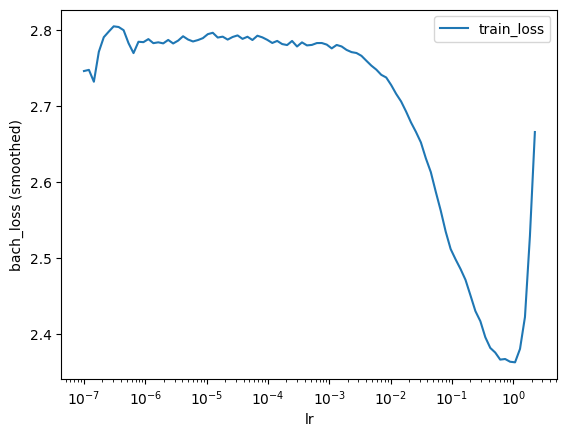

In [25]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [27]:
lr_finder.get_best_lr()

0.10722672220103299

Muitas vezes, essa taxa de aprendizagem é um pouco alta, então a definimos manualmente para 0,01

In [28]:
model.optimizer.set_lr(0.01)

Incluímos o EarlyStopping retorno de chamada para interromper o treinamento quando a perda de validação parar de melhorar. Após o treinamento, esse retorno de chamada também carregará o modelo com melhor desempenho em termos de perda de validação.

In [29]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]


In [30]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.6553,	val_loss: 2.5082
1:	[0s / 0s],		train_loss: 2.3632,	val_loss: 2.3259
2:	[0s / 0s],		train_loss: 2.1561,	val_loss: 2.1035
3:	[0s / 0s],		train_loss: 1.9414,	val_loss: 1.8718
4:	[0s / 0s],		train_loss: 1.7379,	val_loss: 1.6809
5:	[0s / 0s],		train_loss: 1.5686,	val_loss: 1.5452
6:	[0s / 0s],		train_loss: 1.5167,	val_loss: 1.4802
7:	[0s / 0s],		train_loss: 1.4887,	val_loss: 1.4696
8:	[0s / 0s],		train_loss: 1.4744,	val_loss: 1.4757
9:	[0s / 0s],		train_loss: 1.4552,	val_loss: 1.4695
10:	[0s / 0s],		train_loss: 1.4594,	val_loss: 1.4630
11:	[0s / 0s],		train_loss: 1.4374,	val_loss: 1.4620
12:	[0s / 0s],		train_loss: 1.4292,	val_loss: 1.4646
13:	[0s / 0s],		train_loss: 1.4312,	val_loss: 1.4693
14:	[0s / 0s],		train_loss: 1.4135,	val_loss: 1.4664
15:	[0s / 0s],		train_loss: 1.4142,	val_loss: 1.4661
16:	[0s / 0s],		train_loss: 1.4011,	val_loss: 1.4737
17:	[0s / 0s],		train_loss: 1.4110,	val_loss: 1.4806
18:	[0s / 0s],		train_loss: 1.4195,	val_loss: 1.4901
19:

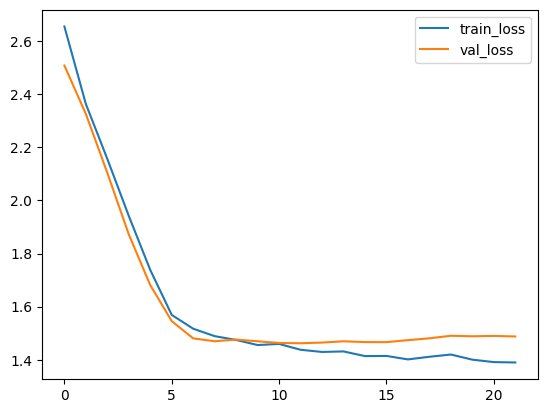

In [31]:
_ = log.plot()

##Previsão
- Para avaliação, precisamos primeiro obter estimativas de sobrevivência para o conjunto de teste. Isso pode ser feito com model.predict_survwhich retorna um array de estimativas de sobrevivência ou com model.predict_surv_dfwhich retorna as estimativas de sobrevivência como um dataframe.

- No entanto, precisamos definir em quantos pontos queremos obter as previsões. O padrão ( model.sub = 1) é usar apenas os nós do intervalo, mas, ao aumentar o model.subargumento, substituímos os nós por um número equidistante de pontos em cada intervalo. Isso é muito semelhante à interpolação de métodos discretos, como LogisticHazarde PMF.

In [33]:
surv = model.predict_surv_df(x_test)

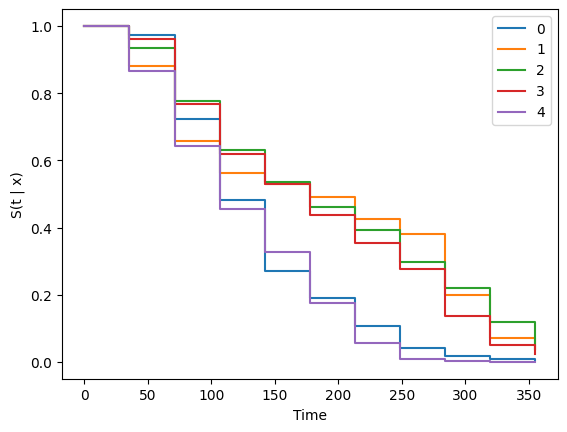

In [34]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [35]:
model.sub = 10

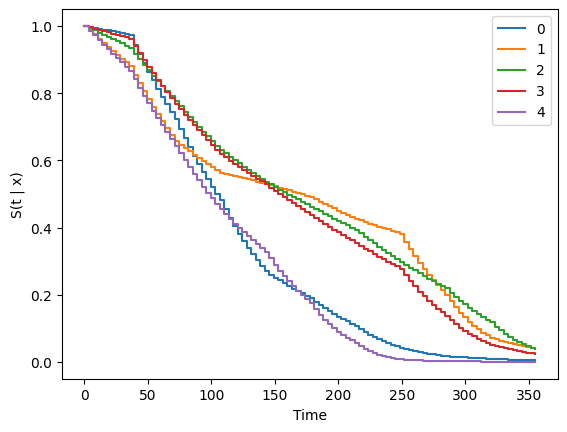

In [36]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

##Avaliação
- A EvalSurvclasse contém alguns critérios de avaliação úteis para a previsão do tempo até o evento. Definimos censor_surv = 'km'que queremos usar Kaplan-Meier para estimar a distribuição de censura.

In [37]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

Concordância
Começamos com a concordância evento-tempo de [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [38]:
ev.concordance_td('antolini')

0.6561108991479079

##Pontuação de Brier
Brier Score

- Podemos plotar a [pontuação de Brier](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) do IPCW para um determinado conjunto de tempos. Aqui, usamos apenas 100 pontos de tempo entre a duração mínima e máxima no conjunto de teste. Observe que a pontuação se torna instável para os tempos mais altos. Portanto, é comum desconsiderar a parte mais à direita do gráfico.

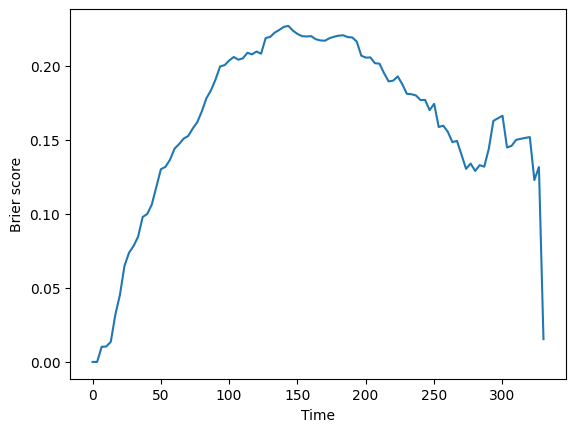

In [39]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

## Log-verossimilhança binomial negativa
De maneira semelhante, podemos traçar o [logaritmo da verossimilhança binomial negativa do IPCW](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

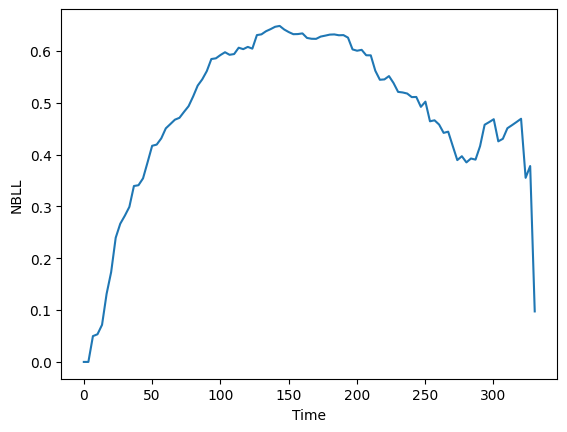

In [40]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

Pontuações integradas
As duas pontuações dependentes do tempo acima podem ser integradas ao longo do tempo para produzir uma única pontuação [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). Na prática, isso é feito por integração numérica sobre um time_grid.

In [41]:
ev.integrated_brier_score(time_grid)

0.1630687951951615

In [42]:
ev.integrated_nbll(time_grid)

0.48249675960098337